In [516]:
import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [517]:
df = pd.read_csv('synthetic_data_v3.csv')

# 1. Structuring the data

In [518]:
df.tail()

,transaction_date,category,product,amount,is_festival,event_name,is_holiday
92010,2025-06-26,topup,smartcell_topup,577.79,True,New Year English,True
92011,2025-06-26,topup,ntc_topup,8326.71,True,New Year English,True
92012,2025-06-26,bill_payment,internet_bill,5243.09,True,New Year English,True
92013,2025-06-26,topup,ncell_topup,5247.09,True,New Year English,True
92014,2025-06-26,loan,loan_repayment,7100.00,True,New Year English,True


In [519]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92015 entries, 0 to 92014
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_date  92015 non-null  object 
 1   category          92015 non-null  object 
 2   product           92015 non-null  object 
 3   amount            92015 non-null  float64
 4   is_festival       92015 non-null  bool   
 5   event_name        12517 non-null  object 
 6   is_holiday        92015 non-null  bool   
dtypes: bool(2), float64(1), object(4)
memory usage: 3.7+ MB


In [520]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

In [521]:

# Set full date range
full_date_range = pd.date_range(start=df['transaction_date'].min(),
                                end=df['transaction_date'].max())

# Get all unique categories or products
all_categories = df['category'].unique()

# Create complete cartesian product of dates and categories
complete_index = pd.MultiIndex.from_product(
    [all_categories, full_date_range],
    names=['category', 'transaction_date']
)

# Group & aggregate per day per category if not already
df_daily = df.groupby(['category', 'transaction_date']) \
    .agg({
            "amount": "sum",
            "is_festival": "max",    # If any row that day is a festival, mark it as True
            "event_name": "first",   # Just keep the first festival name (optional)
            "is_holiday": "max"      # If any row that day is a holiday, mark it as True
        }).reset_index()
                                                        

# Reindex to include all date-category pairs
df_full = df_daily.set_index(['category', 'transaction_date']).reindex(complete_index)

# Fill missing amount with 0
df_full['amount'] = df_full['amount'].fillna(0)

# Reset index for further processing
aggregated_df = df_full.reset_index()



In [522]:
aggregated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9873 entries, 0 to 9872
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   category          9873 non-null   object        
 1   transaction_date  9873 non-null   datetime64[ns]
 2   amount            9873 non-null   float64       
 3   is_festival       9831 non-null   object        
 4   event_name        640 non-null    object        
 5   is_holiday        9831 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 462.9+ KB


In [523]:
aggregated_df['is_festival'] = aggregated_df['is_festival'].astype('bool')
aggregated_df['is_holiday'] = aggregated_df['is_holiday'].astype('bool')

In [524]:
aggregated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9873 entries, 0 to 9872
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   category          9873 non-null   object        
 1   transaction_date  9873 non-null   datetime64[ns]
 2   amount            9873 non-null   float64       
 3   is_festival       9873 non-null   bool          
 4   event_name        640 non-null    object        
 5   is_holiday        9873 non-null   bool          
dtypes: bool(2), datetime64[ns](1), float64(1), object(2)
memory usage: 327.9+ KB


In [525]:
# aggregated_df = df.groupby(["transaction_date", "category"]).agg({
# #     "amount": "sum",
# #     "is_festival": "max",    # If any row that day is a festival, mark it as True
# #     "event_name": "first",   # Just keep the first festival name (optional)
# #     "is_holiday": "max"      # If any row that day is a holiday, mark it as True
# # }).reset_index()# 

In [526]:
aggregated_df.rename(columns={'amount': "transaction_amount"}, inplace=True)

In [527]:
# Step 3: Sort the result
aggregated_df.sort_values(["category", "transaction_date"], inplace=True)

In [528]:
aggregated_df.is_festival.value_counts()

is_festival
False    9228
True      645
Name: count, dtype: int64

In [529]:
aggregated_df.shape

(9873, 6)

# 2. Data Profiling

In [530]:
aggregated_df.event_name.unique()

array(['New Year English', None, 'Maghe Sankranti', "Valentine's Day",
       'Shivaratri', 'Holi', 'New Year Nepali', "Mother's Day",
       'Buddha Jayanti', 'Rakhshya Bandhan', 'Teej', 'Indra Jatra',
       'Dashain Day 1', 'Dashain Day 2', 'Dashain Day 3', 'Dashain Day 4',
       'Dashain Day 5', 'Tihar Day 1', 'Tihar Day 2', 'Tihar Day 3',
       'Tihar Day 4', 'Chhath', 'Christmas', 'Earthquake',
       'Recession Alert', nan], dtype=object)

# 3. Feature Engineering

In [531]:
def classify_event(name):
    if pd.isna(name):
        return "none"
    if name.lower() in ["earthquake", "recession alert"]:
        return "disaster"
    return "festival"

aggregated_df["event_type"] = aggregated_df["event_name"].apply(classify_event)


In [532]:
aggregated_df.event_type.value_counts()

event_type
none        9233
festival     603
disaster      37
Name: count, dtype: int64

### 3.1 Accounting for pre and post event effects

In [533]:
from datetime import timedelta

# Get all event dates by product
event_dates = aggregated_df.dropna(subset=["event_name"])[["transaction_date", "category"]]

# Initialize flags
aggregated_df["pre_event_window"] = False
aggregated_df["post_event_window"] = False

# Loop through events to set flags
for _, row in event_dates.iterrows():
    prod = row["category"]
    date = row["transaction_date"]

    mask_pre = (aggregated_df["category"] == prod) & \
               (aggregated_df["transaction_date"] >= date - timedelta(days=10)) & \
               (aggregated_df["transaction_date"] < date)
    
    mask_post = (aggregated_df["category"] == prod) & \
                (aggregated_df["transaction_date"] > date) & \
                (aggregated_df["transaction_date"] <= date + timedelta(days=10))

    aggregated_df.loc[mask_pre, "pre_event_window"] = True
    aggregated_df.loc[mask_post, "post_event_window"] = True


In [534]:
aggregated_df.head()

,category,transaction_date,transaction_amount,is_festival,event_name,is_holiday,event_type,pre_event_window,post_event_window
4388,bank_transaction,2022-06-26,60158.29,True,New Year English,True,festival,False,False
4389,bank_transaction,2022-06-27,6974.40,False,None,True,none,False,True
4390,bank_transaction,2022-06-28,21683.39,False,None,False,none,False,True
4391,bank_transaction,2022-06-29,25196.15,False,None,False,none,True,True
4392,bank_transaction,2022-06-30,14253.12,False,None,False,none,True,True


In [535]:
# aggregated_df.set_index(['transaction_date'], inplace=True)
#

In [536]:
unique_categories = aggregated_df['category'].unique()

for cat in unique_categories:
    rolling_mean_data = aggregated_df[aggregated_df['category'] == cat]['transaction_amount'].rolling(window=20).mean()
    aggregated_df.loc[aggregated_df['category'] == cat, 'transaction_amount'] = rolling_mean_data

<Axes: >

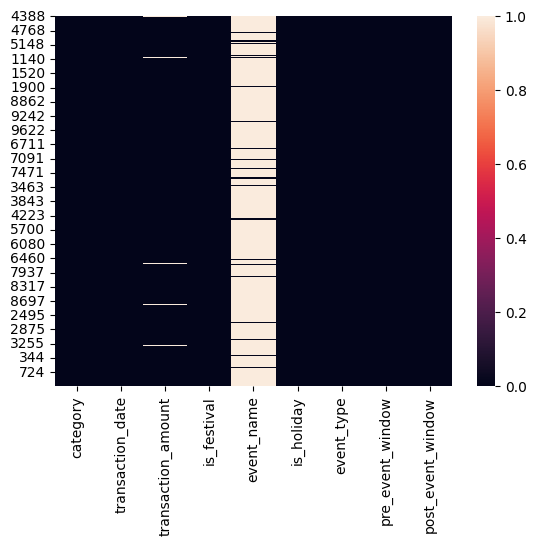

In [537]:
sns.heatmap(aggregated_df.isna())

<Axes: >

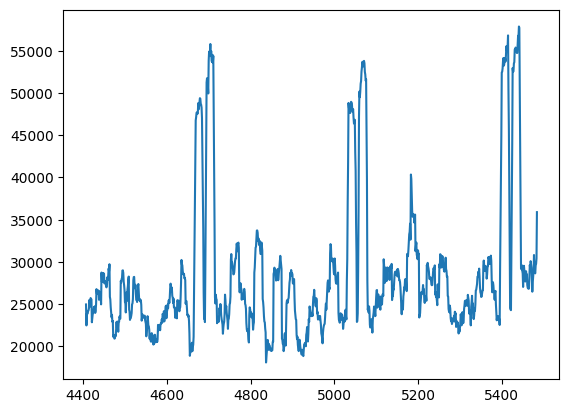

In [538]:
aggregated_df['transaction_amount'][aggregated_df['category'] == 'bank_transaction'].plot()

### 3.2 Making cyclical features for the dates

In [539]:
# Day of Week (0 to 6)
aggregated_df["day_of_week"] = aggregated_df["transaction_date"].dt.dayofweek
# Shift so that Sunday = 1, Monday = 2, ..., Saturday = 7
aggregated_df["day_of_week"] = ((aggregated_df["day_of_week"] + 1) % 7) + 1
aggregated_df["day_of_week_sin"] = np.sin(2 * np.pi * aggregated_df["day_of_week"] / 7)
aggregated_df["day_of_week_cos"] = np.cos(2 * np.pi * aggregated_df["day_of_week"] / 7)

# Month (1 to 12)
aggregated_df["month"] = aggregated_df["transaction_date"].dt.month
aggregated_df["month_sin"] = np.sin(2 * np.pi * aggregated_df["month"] / 12)
aggregated_df["month_cos"] = np.cos(2 * np.pi * aggregated_df["month"] / 12)


# Year (1 to 365)
aggregated_df["day_of_year"] = aggregated_df["transaction_date"].dt.dayofyear
aggregated_df["day_of_year_sin"] = np.sin(2 * np.pi * aggregated_df["day_of_year"] / 365)
aggregated_df["day_of_year_cos"] = np.cos(2 * np.pi * aggregated_df["day_of_year"] / 365)

In [540]:
aggregated_df.drop(columns=["day_of_week", "month", 'day_of_year'], inplace=True)

In [541]:
aggregated_df.shape

(9873, 15)

### 3.3 Removing the unwanted columns

In [542]:
aggregated_df.drop(columns=['event_name'], inplace=True)

### 3.4 Creating Lag features and rolling mean statistics

In [543]:
# Ensure the data is sorted by date
aggregated_df = aggregated_df.sort_values(["category", "transaction_date"])

# Create lag features
for lag in [1, 7, 14]:
    aggregated_df[f"lag_{lag}"] = aggregated_df.groupby("category")["transaction_amount"].shift(lag)


In [544]:
# Create 7-day and 30-day rolling means
for window in [7, 14]:
    aggregated_df[f"rolling_mean_{window}"] = (
        aggregated_df.groupby("category")["transaction_amount"]
        .transform(lambda x: x.shift(1).rolling(window=window).mean())
    )


### 3.4 Droping unwanted rows

In [545]:
aggregated_df.dropna(inplace=True)

In [546]:
aggregated_df.shape

(9576, 19)

# 4. Performing the train-test split

In [547]:
train_list, test_list = [], []

for cat in aggregated_df['category'].unique():
    df_cat = aggregated_df[aggregated_df['category'] == cat]
    cutoff = df_cat['transaction_date'].quantile(0.8)
    
    train_list.append(df_cat[df_cat['transaction_date'] <= cutoff])
    test_list.append(df_cat[df_cat['transaction_date'] > cutoff])

train_df = pd.concat(train_list)
test_df = pd.concat(test_list)


In [548]:
train_df.head()

,category,transaction_date,transaction_amount,is_festival,is_holiday,event_type,pre_event_window,post_event_window,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_of_year_sin,day_of_year_cos,lag_1,lag_7,lag_14,rolling_mean_7,rolling_mean_14
4421,bank_transaction,2022-07-29,22844.2340,False,False,none,False,False,-7.818315e-01,0.623490,-0.500000,-0.866025,-0.455907,-0.890028,25562.9185,24518.4940,24956.4940,25217.573286,24573.682643
4422,bank_transaction,2022-07-30,23323.2070,False,False,none,True,False,-2.449294e-16,1.000000,-0.500000,-0.866025,-0.471160,-0.882048,22844.2340,25486.0130,22472.6535,24978.393286,24422.806929
4423,bank_transaction,2022-07-31,23804.5555,False,False,none,True,False,7.818315e-01,0.623490,-0.500000,-0.866025,-0.486273,-0.873807,23323.2070,24677.9035,23873.4950,24669.421000,24483.560750
4424,bank_transaction,2022-08-01,23914.8870,False,True,none,True,False,9.749279e-01,-0.222521,-0.866025,-0.500000,-0.501242,-0.865307,23804.5555,24956.4665,23872.2785,24544.657000,24478.636500
4425,bank_transaction,2022-08-02,24207.1215,False,False,none,True,False,4.338837e-01,-0.900969,-0.866025,-0.500000,-0.516062,-0.856551,23914.8870,25716.5325,23878.7145,24395.859929,24481.679964


### 4.1 Dropping unwanted features 

In [549]:
train_df.drop(columns=['transaction_date'], inplace=True)
test_df.drop(columns=['transaction_date'], inplace=True)

#### 4.1.1 Encoding the categorical features using Target Encoding and One-Hot Encoding

In [550]:
# Step 1: Compute mean target value per category (from training data only)
category_target_mean = train_df.groupby('category')['transaction_amount'].mean()

# Step 2: Map encoded values to both train and test sets
train_df['category'] = train_df['category'].map(category_target_mean)
test_df['category'] = test_df['category'].map(category_target_mean)

# Step 3 (optional): Fill NaNs in test set (in case unseen categories exist)
global_mean = train_df['transaction_amount'].mean()
test_df['category'].fillna(global_mean, inplace=True)


C:\Users\JARVIS\AppData\Local\Temp\ipykernel_15068\1161719989.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['category'].fillna(global_mean, inplace=True)


In [551]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# 2. Create and fit encoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(train_df[['event_type']])

# 3. Transform both train and test
train_encoded = encoder.transform(train_df[['event_type']])
test_encoded = encoder.transform(test_df[['event_type']])

# 4. Get encoded column names
encoded_cols = encoder.get_feature_names_out(['event_type'])

# 5. Convert to DataFrame
train_encoded_df = pd.DataFrame(train_encoded, columns=encoded_cols, index=train_df.index)
test_encoded_df = pd.DataFrame(test_encoded, columns=encoded_cols, index=test_df.index)

# 6. Merge with original DataFrames
train_df = pd.concat([train_df.drop(columns=['event_type']), train_encoded_df], axis=1)
test_df = pd.concat([test_df.drop(columns=['event_type']), test_encoded_df], axis=1)


In [552]:
X_train = train_df.dropna(subset=['transaction_amount'])
X_test = test_df.dropna(subset=['transaction_amount'])

y_train = train_df['transaction_amount']
y_test = test_df['transaction_amount']


In [553]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7659 entries, 4421 to 883
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   category             7659 non-null   float64
 1   transaction_amount   7659 non-null   float64
 2   is_festival          7659 non-null   bool   
 3   is_holiday           7659 non-null   bool   
 4   pre_event_window     7659 non-null   bool   
 5   post_event_window    7659 non-null   bool   
 6   day_of_week_sin      7659 non-null   float64
 7   day_of_week_cos      7659 non-null   float64
 8   month_sin            7659 non-null   float64
 9   month_cos            7659 non-null   float64
 10  day_of_year_sin      7659 non-null   float64
 11  day_of_year_cos      7659 non-null   float64
 12  lag_1                7659 non-null   float64
 13  lag_7                7659 non-null   float64
 14  lag_14               7659 non-null   float64
 15  rolling_mean_7       7659 non-null   floa

# 5. Training the model

In [554]:
from xgboost import XGBRegressor

# Train
model_xgb = XGBRegressor(n_estimators=100)
model_xgb.fit(X_train, y_train)

# Predict
y_pred = model_xgb.predict(X_test)

# 6. Evaluation

In [557]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7659 entries, 4421 to 883
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   category             7659 non-null   float64
 1   transaction_amount   7659 non-null   float64
 2   is_festival          7659 non-null   bool   
 3   is_holiday           7659 non-null   bool   
 4   pre_event_window     7659 non-null   bool   
 5   post_event_window    7659 non-null   bool   
 6   day_of_week_sin      7659 non-null   float64
 7   day_of_week_cos      7659 non-null   float64
 8   month_sin            7659 non-null   float64
 9   month_cos            7659 non-null   float64
 10  day_of_year_sin      7659 non-null   float64
 11  day_of_year_cos      7659 non-null   float64
 12  lag_1                7659 non-null   float64
 13  lag_7                7659 non-null   float64
 14  lag_14               7659 non-null   float64
 15  rolling_mean_7       7659 non-null   floa

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

mae_xgb = mean_absolute_error(y_test, y_pred)
print("MAE:", mae_xgb)

r2_xgb = r2_score(y_test, y_pred)
print("R-squared:", r2_xgb)

mape_xgb = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE:", mape_xgb)

MAE: 188.0205802849505
R-squared: 0.9979810359470763
MAPE: 0.004004543288483104


# 7. Forecasting

In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta

def forecast_next_7_days(category_name, model, original_df, category_target_mean, global_mean):
    # Step 1: Filter past data for this category
    df_cat = original_df[original_df['category'] == category_name].copy()
    df_cat.sort_values('transaction_date', inplace=True)
    df_cat.reset_index(drop=True, inplace=True)

    # Step 2: Prepare future dates
    last_date = df_cat['transaction_date'].max()
    future_dates = [last_date + timedelta(days=i+1) for i in range(7)]

    forecasts = []
    
    for forecast_date in future_dates:
        row = {}
        row['transaction_date'] = forecast_date

        # === Static Features ===
        row['category'] = category_target_mean.get(category_name, global_mean)
        row['is_festival'] = False
        row['is_holiday'] = False
        row['pre_event_window'] = False
        row['post_event_window'] = False

        # === Cyclical Features ===
        dow = forecast_date.weekday()  # Monday=0
        row['day_of_week_sin'] = np.sin(2 * np.pi * dow / 7)
        row['day_of_week_cos'] = np.cos(2 * np.pi * dow / 7)

        month = forecast_date.month
        row['month_sin'] = np.sin(2 * np.pi * month / 12)
        row['month_cos'] = np.cos(2 * np.pi * month / 12)

        day_of_year = forecast_date.timetuple().tm_yday
        row['day_of_year_sin'] = np.sin(2 * np.pi * day_of_year / 365)
        row['day_of_year_cos'] = np.cos(2 * np.pi * day_of_year / 365)

        # === One-hot Event Type ===
        row['event_type_festival'] = 0
        row['event_type_disaster'] = 0
        row['event_type_none'] = 1

        # === Lag and Rolling ===
        # Make sure to handle missing lag values (e.g. beginning of series)
        try:
            row['lag_1'] = df_cat.iloc[-1]['transaction_amount']
            row['lag_7'] = df_cat.iloc[-7]['transaction_amount'] if len(df_cat) >= 7 else row['lag_1']
            row['lag_14'] = df_cat.iloc[-14]['transaction_amount'] if len(df_cat) >= 14 else row['lag_7']
        except IndexError:
            row['lag_1'] = row['lag_7'] = row['lag_14'] = df_cat['transaction_amount'].mean()

        row['rolling_mean_7'] = df_cat['transaction_amount'].rolling(window=7).mean().iloc[-1] if len(df_cat) >= 7 else df_cat['transaction_amount'].mean()
        row['rolling_mean_14'] = df_cat['transaction_amount'].rolling(window=14).mean().iloc[-1] if len(df_cat) >= 14 else df_cat['transaction_amount'].mean()

        # Convert to DataFrame and predict
        X = pd.DataFrame([row])
        prediction = model.predict(X)[0]
        row['predicted_amount'] = prediction

        # Append to results
        forecasts.append(row)

        # Append to df_cat to maintain rolling window
        df_cat = pd.concat([df_cat, pd.DataFrame({
            'transaction_date': [forecast_date],
            'category': [category_name],
            'transaction_amount': [prediction]
        })], ignore_index=True)

    return pd.DataFrame(forecasts)
